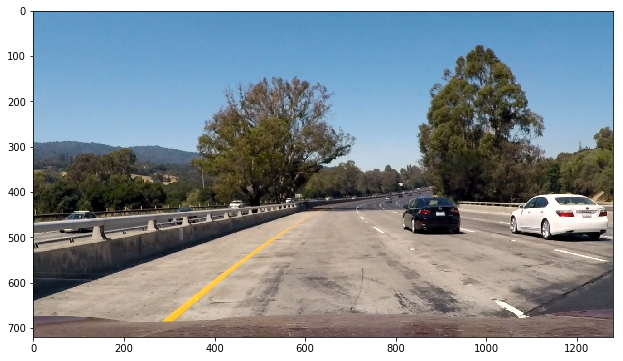

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filename = './test_images/test1.jpg'

image = mpimg.imread(filename)
plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.show()

(720, 1280, 3)


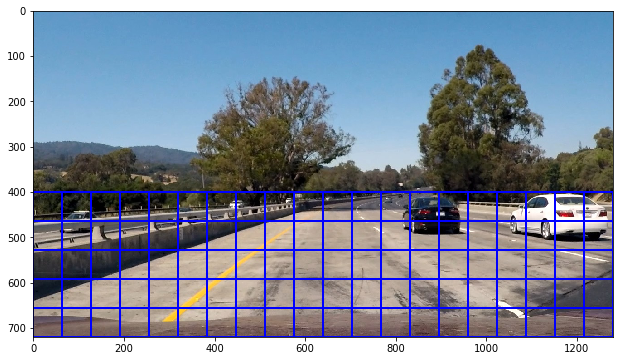

In [32]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    x_start = x_start_stop[0] if x_start_stop[0] else 0
    y_start = y_start_stop[0] if y_start_stop[0] else 0
    x_stop = x_start_stop[1] if x_start_stop[1] else img.shape[0]
    y_stop = y_start_stop[1] if y_start_stop[1] else img.shape[1]
    window_w = xy_window[0]
    window_h = xy_window[1]
    
    x_step = np.int(window_w * xy_overlap[0])
    y_step = np.int(window_h * xy_overlap[1])
    x_stop = x_stop - window_w
    y_stop = y_stop - window_h
    
    for top in range(y_start, y_stop+1, y_step):
        for left in range(x_start, x_stop+1, x_step):
            top_left = (top, left)
            bottom_right = (top + window_w, left + window_h)
            window_list.append((top_left, bottom_right))
            
    return window_list

print(image.shape)
windows = slide_window(image, x_start_stop=(400, 720), y_start_stop=(0,1280), xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=3)                    

plt.figure(figsize=(12, 6))
plt.imshow(window_img)
plt.show()

def window_img(img, window):
    top_left, bottom_right = window
    square_img = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0], :]
    return square_img

# windows = slide_window(image, x_start_stop=(380, 480), y_start_stop=(450,880), xy_window=(64, 64), xy_overlap=(0.5, 0.5))
# window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=3)                    

# windows = slide_window(image, x_start_stop=(380, 572), y_start_stop=(350,1050), xy_window=(128, 128), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=3)                    

# windows = slide_window(image, x_start_stop=(380, 650), y_start_stop=(250,1280), xy_window=(192, 192), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(window_img, windows, color=(255, 255, 0), thick=3)                    

# windows = slide_window(image, x_start_stop=(380, 720), y_start_stop=(150,1280), xy_window=(256, 256), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=3)                    



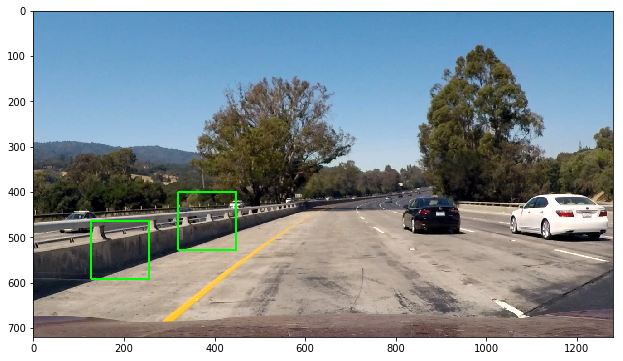

In [31]:
import pickle
from skimage.feature import hog


convertors = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb,
    'Lab': cv2.COLOR_BGR2Lab,
    'Luv': cv2.COLOR_BGR2Luv,
}

def color_hist(img, nbins=32, bins_range=(0, 256), color_space='RGB', visualize=False):
    convertor = convertors[color_space]
    img = cv2.cvtColor(img, convertor)
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    if visualize:
        print(features.shape)
        return features, (hist0, hist1, hist2)
    else:
        return features
    
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    convertor = convertors[color_space]
    feature_img = cv2.cvtColor(img, convertor)
    features = cv2.resize(feature_img, size).ravel()
    return features

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=vis, feature_vector=feature_vec)

def extract_features(img):
    color_hist_features = color_hist(img, color_space='HLS')
    bin_spatial_features = bin_spatial(img, color_space='Lab')
    
    yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    channel1 = get_hog_features(yuv_img[:,:,0]).ravel()
    channel2 = get_hog_features(yuv_img[:,:,1]).ravel()
    channel3 = get_hog_features(yuv_img[:,:,2]).ravel()

    return np.concatenate((color_hist_features, bin_spatial_features, channel1, channel2, channel3))



classifier, feature_select, X_scaler = None, None, None
with open('./classifier.pkl', 'rb') as f:
    data = pickle.load(f)
    classifier = data['classifier']
    feature_select = data['feature_select']
    X_scaler = data['X_scaler']

def is_vehicle(img):
    img = cv2.resize(img, (64, 64))
    X = extract_features(img).astype(np.float64)
    X = X.reshape(1, -1)
#     print(X.shape)
    scaled_X = X_scaler.transform(X)
#     print(scaled_X.shape)
    X_new = feature_select.transform(scaled_X).ravel()
#     print(X_new.shape)
    result = classifier.predict([X_new])
    return result == 1
    
car_windows = []
    
for window in windows:
    square_img = window_img(image, window)
    if is_vehicle(square_img):
        car_windows.append(window)

img_with_boxes = draw_boxes(image, car_windows, color=(0, 255, 0), thick=3)                    
plt.figure(figsize=(12, 6))
plt.imshow(img_with_boxes)
plt.show()
    